# 展示贪吃蛇游戏训练成果

## 模型预定义

In [1]:
import os
import time
from pathlib import Path
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms as T
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.multiprocessing as mp

In [2]:
# ———————————————— 模型组件 ————————————————
class ConvBlock(nn.Module):
    """Conv→BN→ReLU"""
    def __init__(self, c_in, c_out, k=3, s=1, p=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, k, s, p, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)


class SnakeEncoder(nn.Module):
    """
    Downsample ×2 + Residual ×2 → 输出 [B, emb_dim, 16,16]
    """
    def __init__(self, emb_dim=64):
        super().__init__()
        self.enc = nn.Sequential(
            ConvBlock(3,  32, k=4, s=2, p=1),  # 64→32
            ConvBlock(32, 64, k=4, s=2, p=1),  # 32→16
            ConvBlock(64, 64),                 # 保持 16×16
            ConvBlock(64, 64),
        )
        self.project = nn.Conv2d(64, emb_dim, kernel_size=1)

    def forward(self, x):
        h = self.enc(x)
        return self.project(h)  # [B, emb_dim,16,16]


class SnakeDecoder(nn.Module):
    """
    对称 Decoder: [B,emb_dim,16,16] → [B,3,64,64]
    """
    def __init__(self, emb_dim=64):
        super().__init__()
        self.project = nn.Conv2d(emb_dim, 64, kernel_size=1)
        self.dec = nn.Sequential(
            ConvBlock(64, 64),
            ConvBlock(64, 32),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),  #16→32
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3,  kernel_size=4, stride=2, padding=1),  #32→64
            nn.Sigmoid(),  # 输出 [0,1]
        )

    def forward(self, z_q):
        h = self.project(z_q)
        return self.dec(h)


class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int, beta: float = 0.25):
        super().__init__()
        self.K = num_embeddings
        self.D = embedding_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.K, self.D)
        self.embedding.weight.data.uniform_(-1/self.K, 1/self.K)

    def forward(self, z_e: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        B, D, H, W = z_e.shape
        flat = z_e.permute(0,2,3,1).reshape(-1, D)  # [B*H*W, D]

        # L2
        dist = (flat.pow(2).sum(1,keepdim=True)
                - 2 * flat @ self.embedding.weight.t()
                + self.embedding.weight.pow(2).sum(1))
        idx = dist.argmin(1)  # [B*H*W]
        z_q = self.embedding(idx).view(B, H, W, D).permute(0,3,1,2)

        # VQ loss
        loss_commit = F.mse_loss(z_q.detach(), z_e)
        loss_embed  = F.mse_loss(z_q, z_e.detach())
        vq_loss = loss_embed + self.beta * loss_commit

        # straight-through
        z_q = z_e + (z_q - z_e).detach()
        return z_q, vq_loss


class VQVAE(nn.Module):
    def __init__(self, num_embeddings=128, embedding_dim=64, beta=0.25):
        super().__init__()
        self.enc = SnakeEncoder(emb_dim=embedding_dim)
        self.vq  = VectorQuantizer(num_embeddings, embedding_dim, beta)
        self.dec = SnakeDecoder(emb_dim=embedding_dim)

    def encode(self, x: torch.Tensor) -> torch.LongTensor:
        z_e = self.enc(x)               # [B, D, H, W]
        B, D, H, W = z_e.shape
        flat = z_e.permute(0,2,3,1).reshape(-1, D)  # [B*H*W, D]
        # 注意这里是 self.vq.embedding
        dist = (flat.pow(2).sum(1, keepdim=True)
                - 2 * flat @ self.vq.embedding.weight.t()
                + self.vq.embedding.weight.pow(2).sum(1))
        idx = dist.argmin(1)                            # [B*H*W]
        return idx.view(B, H, W)                       # [B, H, W]

    def decode(self, idx: torch.LongTensor) -> torch.Tensor:
        B, H, W = idx.shape
        flat = idx.view(-1)
        # 这里也用 self.vq.embedding
        emb = self.vq.embedding.weight               # [K, D]
        z_q = emb[flat].view(B, H, W, -1).permute(0,3,1,2)  # [B, D, H, W]
        return self.dec(z_q)                         # [B, 3, 64, 64]

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        z_e = self.enc(x)
        z_q, vq_loss = self.vq(z_e)
        x_hat = self.dec(z_q)
        return x_hat, vq_loss





# —————— 构造 (frame_t → frame_{t+1}) token 数据集 ——————
class SequenceFrameDataset(Dataset):
    def __init__(self, root_dir:str, vqvae:VQVAE, device, transform=None):
        self.vqvae = vqvae.to(device).eval()
        self.device = device
        self.transform = transform or T.Compose([
            T.Resize((64,64)), T.ToTensor()
        ])
        self.pairs = []
        for run_dir in sorted(Path(root_dir).glob('run_*')):
            frames = sorted(run_dir.glob('*.png'))
            for i in range(len(frames)-1):
                self.pairs.append((frames[i], frames[i+1]))
        print(f"Total frame‐pairs: {len(self.pairs)}")
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        p0, p1 = self.pairs[idx]
        img0 = Image.open(p0).convert('RGB')
        img1 = Image.open(p1).convert('RGB')
        x0 = self.transform(img0).unsqueeze(0).to(self.device)
        x1 = self.transform(img1).unsqueeze(0).to(self.device)
        with torch.no_grad():
            idx0 = self.vqvae.encode(x0)  # [1,16,16]
            idx1 = self.vqvae.encode(x1)
        return idx0.view(-1), idx1.view(-1)  # ([256], [256])


# —————— Transformer 预测器 ——————
class TokenPredictor(nn.Module):
    def __init__(self, num_embeddings=256, emb_dim=64, n_head=8, num_layers=4):
        super().__init__()
        self.seq_len = 16*16
        self.token_emb = nn.Embedding(num_embeddings, emb_dim)
        self.pos_emb   = nn.Parameter(torch.randn(1, self.seq_len, emb_dim))
        layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=n_head,
            batch_first=True, dim_feedforward=emb_dim*4)
        self.transformer = nn.TransformerEncoder(layer, num_layers)
        self.head = nn.Linear(emb_dim, num_embeddings)
    def forward(self, seq:torch.LongTensor) -> torch.Tensor:
        # seq: [B, seq_len]
        x = self.token_emb(seq) + self.pos_emb  # [B,seq_len,D]
        x = self.transformer(x)                 # [B,seq_len,D]
        return self.head(x)                     # [B,seq_len,K]

## 预测下一帧的函数
输入一个图片，预测下一个图片

In [3]:
def show_predicted(image: Image.Image, vqvae, predictor, device):
    """
    输入一帧 PIL Image，返回预测的下一帧 PIL Image
    """
    vqvae.eval()
    predictor.eval()

    transform = T.Compose([
        T.Resize((64,64)),
        T.ToTensor(),      # [0,1]
    ])
    to_pil = T.ToPILImage()

    # 预处理
    x = transform(image).unsqueeze(0).to(device)  # [1,3,64,64]

    with torch.no_grad():
        # 编码为索引序列
        idx = vqvae.encode(x).view(1, -1)            # [1,256]
        # 预测下一个索引
        logits = predictor(idx)                      # [1,256,K]
        next_idx = logits.argmax(-1).view(1,16,16)   # [1,16,16]
        # 解码为图像
        pred = vqvae.decode(next_idx)                # [1,3,64,64]

    # 后处理并返回 PIL Image
    pred = pred.squeeze(0).cpu().clamp(0,1)         # [3,64,64]
    return to_pil(pred)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vqvae = VQVAE(num_embeddings=128, embedding_dim=64).to(device)
vqvae.load_state_dict(torch.load('weights/vqvae_20250607_155540.pth', map_location=device))

predictor = TokenPredictor(
    num_embeddings=256,
    emb_dim=64,
    n_head=8,
    num_layers=4
)

predictor.load_state_dict(torch.load('weights/predictor_20250607_220618.pth', map_location=device))
predictor.to(device)

/tmp/ipykernel_3180945/4287613190.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vqvae.load_state_dict(torch.load('weights/vqvae_20250607_155540.pth', map_location=devi

TokenPredictor(
  (token_emb): Embedding(256, 64)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (head): Linear(in_features=64, out_features=256, bias=True)
)

/tmp/ipykernel_3180945/2117890571.py:30: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/2117890571.py:30: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/2117890571.py:30: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/2117890571.py:30: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/2117890571.py:30: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/2117890571.py:30: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/2117890571.py:30: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from curren

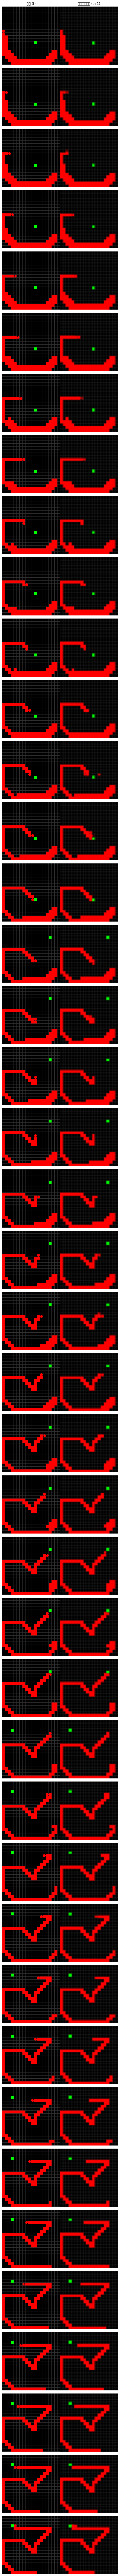

In [ ]:
root_dir = 'test_3'
raw_images = []
filenames  = []
for fname in sorted(os.listdir(root_dir)):
    if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    img_path = os.path.join(root_dir, fname)
    raw_images.append(Image.open(img_path).convert('RGB'))
    filenames.append(fname)

# 2) 用模型预测下一帧
pred_images = []
for img in raw_images:
    pred = show_predicted(img, vqvae, predictor, device)  # 返回 PIL.Image
    pred_images.append(pred)

# 3) 可视化：两列，多行
n = len(raw_images)
fig, axes = plt.subplots(n, 2, figsize=(6, 3*n), squeeze=False)
for i, (orig, pred) in enumerate(zip(raw_images, pred_images)):
    axes[i][0].imshow(orig)
    axes[i][0].axis('off')
    if i == 0:
        axes[i][0].set_title('raw (t)')
    axes[i][1].imshow(pred)
    axes[i][1].axis('off')
    if i == 0:
        axes[i][1].set_title('next (t+1)')

plt.tight_layout()
plt.show()

/tmp/ipykernel_3180945/731069606.py:56: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/731069606.py:56: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/731069606.py:56: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/731069606.py:56: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.tight_layout()


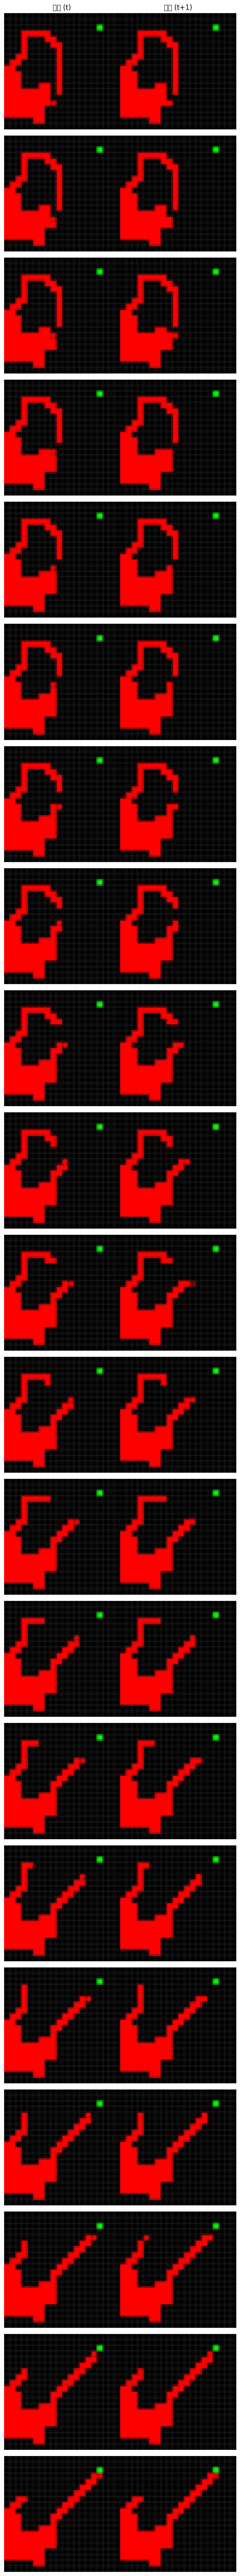

✅ GIF 已保存到 videos/snake_predictions_1.gif


In [23]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms as T

# 1) 先定义 side‐by‐side 和 GIF 生成函数
def make_side_by_side(orig: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """将两张同样尺寸的 H×W×C 图像水平拼接为 H×(2W)×C"""
    return np.concatenate([orig, pred], axis=1)

def images_to_gif(raw_frames, pred_frames, output_path='snake_predictions.gif', fps=10):
    duration = 1 / fps
    with imageio.get_writer(output_path, mode='I', duration=duration) as writer:
        for orig_np, pred_np in zip(raw_frames, pred_frames):
            frame = make_side_by_side(orig_np, pred_np)
            writer.append_data(frame)
    print(f"✅ GIF 已保存到 {output_path}")

# 2) 读取并统一大小
root_dir = 'test_1'
size = (64, 64)  # 预测图大小
raw_images = []
filenames  = []
for fname in sorted(os.listdir(root_dir)):
    if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    img = Image.open(os.path.join(root_dir, fname)).convert('RGB')
    img = img.resize(size, Image.BILINEAR)  # 统一到 64×64
    raw_images.append(img)
    filenames.append(fname)

# 3) 预测并转为 numpy
pred_images = []
for img in raw_images:
    pred = show_predicted(img, vqvae, predictor, device)  # 返回同样 64×64 的 PIL.Image
    pred_images.append(pred)

# 把 PIL → numpy H×W×C
raw_np  = [np.array(img) for img in raw_images]
pred_np = [np.array(img) for img in pred_images]

# 4) 展示前几帧 side-by-side（可选）
n = len(raw_np)
fig, axes = plt.subplots(n, 2, figsize=(6, 3*n), squeeze=False)
for i in range(n):
    axes[i][0].imshow(raw_np[i])
    axes[i][0].axis('off')
    if i == 0:
        axes[i][0].set_title('原图 (t)')
    axes[i][1].imshow(pred_np[i])
    axes[i][1].axis('off')
    if i == 0:
        axes[i][1].set_title('预测 (t+1)')
plt.tight_layout()
plt.show()

# 5) 生成 GIF
os.makedirs('videos', exist_ok=True)
images_to_gif(raw_np, pred_np, output_path='videos/snake_predictions_1.gif', fps=10)


## 自预测

/tmp/ipykernel_3180945/334623790.py:33: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/334623790.py:33: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/334623790.py:33: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/334623790.py:33: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/334623790.py:33: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/334623790.py:33: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3180945/334623790.py:33: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.

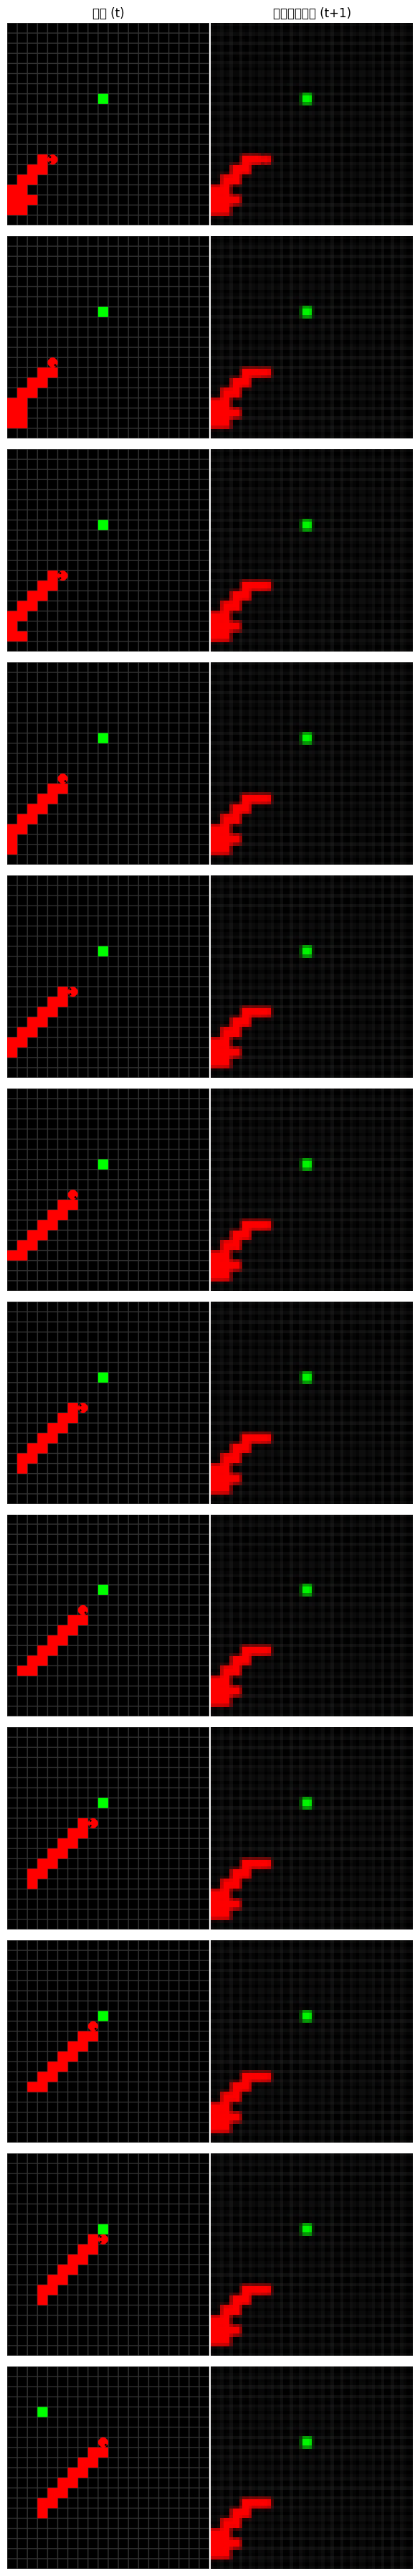

In [13]:
root_dir = 'test_2'
raw_images = []
filenames  = []
for fname in sorted(os.listdir(root_dir)):
    if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    img_path = os.path.join(root_dir, fname)
    raw_images.append(Image.open(img_path).convert('RGB'))
    filenames.append(fname)

# 2) 用模型预测下一帧
pred_images = []
pred = show_predicted(raw_images[0], vqvae, predictor, device)  # 返回 PIL.Image
pred_images.append(pred)

for img_index in range(len(raw_images)-1):
    pred = show_predicted(pred_images[-1], vqvae, predictor, device)  # 返回 PIL.Image
    pred_images.append(pred)

# 3) 可视化：两列，多行
n = len(raw_images)
fig, axes = plt.subplots(n, 2, figsize=(6, 3*n), squeeze=False)
for i, (orig, pred) in enumerate(zip(raw_images, pred_images)):
    axes[i][0].imshow(orig)
    axes[i][0].axis('off')
    if i == 0:
        axes[i][0].set_title('原图 (t)')
    axes[i][1].imshow(pred)
    axes[i][1].axis('off')
    if i == 0:
        axes[i][1].set_title('预测的下一帧 (t+1)')

plt.tight_layout()
plt.show()